# SARIMA Models and Complete Model Comparison

## Learning Objectives
By the end of this notebook, you will be able to:
1. Understand why ARIMA struggles with seasonality
2. Explain what SARIMA adds to ARIMA
3. Build and evaluate SARIMA models using auto-SARIMA
4. Compare all forecasting methods comprehensively
5. Choose the best model for your data


## Introduction: Why SARIMA?

**ARIMA is powerful, but it has a limitation: it doesn't explicitly handle seasonality!**

We saw in our airline passenger data:
- Strong yearly seasonality (summer peaks, winter lows)
- ARIMA might miss this pattern
- We need a model that understands seasonality

**Enter SARIMA: Seasonal ARIMA**

SARIMA adds seasonal components to ARIMA, making it perfect for data with:
- Yearly patterns (like our airline data)
- Monthly patterns
- Weekly patterns
- Any repeating seasonal cycle

**Think of it like this:** 
- **ARIMA:** "I see a trend, but I'm not sure about these repeating patterns..."
- **SARIMA:** "I see the trend AND I understand the seasonal cycle!"

**Real-World Example:** A retailer forecasting sales needs to understand:
- The overall growth trend (ARIMA handles this)
- The December holiday spike (SARIMA handles this explicitly)

**Think About It:** Why do you think explicitly modeling seasonality would be better than just hoping ARIMA figures it out?


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')

print("Libraries imported successfully")
print("Ready to build SARIMA models and compare all methods")


Libraries imported successfully
Ready to build SARIMA models and compare all methods


In [11]:
# Load and prepare the data
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Split into train and test (time-aware split)
split_point = int(len(data) * 0.8)
train = data.iloc[:split_point].copy()
test = data.iloc[split_point:].copy()

print("✅ Data loaded and split successfully")
print(f"Training: {train.index.min()} to {train.index.max()} ({len(train)} months)")
print(f"Testing: {test.index.min()} to {test.index.max()} ({len(test)} months)")
print(f"\n💡 This data has strong yearly seasonality (12 months)")
print("   Perfect for testing SARIMA")


✅ Data loaded and split successfully
Training: 1949-01-01 00:00:00 to 1958-07-01 00:00:00 (115 months)
Testing: 1958-08-01 00:00:00 to 1960-12-01 00:00:00 (29 months)

💡 This data has strong yearly seasonality (12 months)
   Perfect for testing SARIMA


## Section 1: Understanding SARIMA

### What is SARIMA?

**SARIMA = Seasonal AutoRegressive Integrated Moving Average**

SARIMA extends ARIMA by adding seasonal components:
- **ARIMA(p, d, q):** Regular ARIMA parameters
- **SARIMA(p, d, q)(P, D, Q, s):** Adds seasonal parameters

### SARIMA Parameters Explained

**Regular parameters (same as ARIMA):**
- **p:** Number of past values to use (AR)
- **d:** Number of times to difference (I)
- **q:** Number of past errors to use (MA)

**Seasonal parameters (NEW):**
- **P:** Number of seasonal past values to use (Seasonal AR)
- **D:** Number of seasonal differences (Seasonal I)
- **Q:** Number of seasonal past errors to use (Seasonal MA)
- **s:** Length of season (12 for monthly data with yearly seasonality)

**Example: SARIMA(1, 1, 1)(1, 1, 1, 12)**
- Regular: p=1, d=1, q=1 (same as ARIMA)
- Seasonal: P=1, D=1, Q=1, s=12 (handles yearly seasonality)

**Think of it like this:** SARIMA has two "brains":
1. **Regular brain:** Understands short-term patterns (like ARIMA)
2. **Seasonal brain:** Understands long-term repeating patterns (the new part)

### Why SARIMA for Our Data?

Our airline data has:
- ✅ Upward trend (handled by d parameter)
- ✅ Yearly seasonality (handled by seasonal parameters with s=12)
- ✅ Strong seasonal patterns (summer peaks, winter lows)

**Perfect candidate for SARIMA**


## Section 2: Building a SARIMA Model

### Using Auto-SARIMA

Just like with ARIMA, we'll use auto-SARIMA to automatically find the best parameters. This is much easier than choosing them manually!

### Step 1: Prepare the Data

SARIMA needs stationary data. Let's apply Box-Cox transform:


In [12]:
# Apply Box-Cox transform to stabilize variance
train_boxcox, lambda_param = boxcox(train['#Passengers'])

print("✅ Box-Cox transform applied")
print(f"Lambda parameter: {lambda_param:.4f}")


✅ Box-Cox transform applied
Lambda parameter: 0.0449


### Step 2: Build SARIMA Model with Auto-SARIMA

Auto-SARIMA will automatically find the best regular AND seasonal parameters:


In [13]:
# Use auto_arima with seasonal=True to build SARIMA model
# This automatically finds best (p, d, q)(P, D, Q, s) parameters
print("🔍 Auto-SARIMA is searching for the best model...")
print("   This searches for both regular AND seasonal parameters")
print("   It may take a few minutes - be patient")

sarima_model = auto_arima(train_boxcox,
                          start_p=0, start_q=0,
                          max_p=3, max_q=3,
                          d=1,                    # Regular differencing
                          seasonal=True,           # Enable seasonality
                          m=12,                    # Season length (12 months = yearly)
                          start_P=0, start_Q=0,
                          max_P=2, max_Q=2,
                          D=1,                    # Seasonal differencing
                          stepwise=True,
                          suppress_warnings=True,
                          error_action='ignore',
                          trace=False)

print("✅ Auto-SARIMA found the best model")
print(f"\nBest SARIMA model: {sarima_model.order} x {sarima_model.seasonal_order}")
print(f"\nRegular parameters:")
print(f"   p = {sarima_model.order[0]} (AR - uses {sarima_model.order[0]} past values)")
print(f"   d = {sarima_model.order[1]} (I - differences {sarima_model.order[1]} times)")
print(f"   q = {sarima_model.order[2]} (MA - uses {sarima_model.order[2]} past errors)")
print(f"\nSeasonal parameters:")
print(f"   P = {sarima_model.seasonal_order[0]} (Seasonal AR)")
print(f"   D = {sarima_model.seasonal_order[1]} (Seasonal differencing)")
print(f"   Q = {sarima_model.seasonal_order[2]} (Seasonal MA)")
print(f"   s = {sarima_model.seasonal_order[3]} (Season length: {sarima_model.seasonal_order[3]} months)")
print(f"\n💡 Auto-SARIMA found the best combination automatically")


🔍 Auto-SARIMA is searching for the best model...
   This searches for both regular AND seasonal parameters
   It may take a few minutes - be patient
✅ Auto-SARIMA found the best model

Best SARIMA model: (0, 1, 1) x (0, 1, 1, 12)

Regular parameters:
   p = 0 (AR - uses 0 past values)
   d = 1 (I - differences 1 times)
   q = 1 (MA - uses 1 past errors)

Seasonal parameters:
   P = 0 (Seasonal AR)
   D = 1 (Seasonal differencing)
   Q = 1 (Seasonal MA)
   s = 12 (Season length: 12 months)

💡 Auto-SARIMA found the best combination automatically


### Step 3: Generate SARIMA Forecasts

Now let's forecast using our SARIMA model:


In [14]:
# Generate SARIMA forecasts
sarima_forecasts_boxcox = sarima_model.predict(n_periods=len(test))

# Convert back to original scale
sarima_forecasts = inv_boxcox(sarima_forecasts_boxcox, lambda_param)

print("✅ SARIMA forecasts generated")
print(f"Forecasted {len(sarima_forecasts)} future periods")
print(f"Forecast range: {sarima_forecasts.min():.0f} to {sarima_forecasts.max():.0f} passengers")


✅ SARIMA forecasts generated
Forecasted 29 future periods
Forecast range: 323 to 588 passengers


## Section 3: Visualizing SARIMA Forecasts

Let's see how well SARIMA performs:


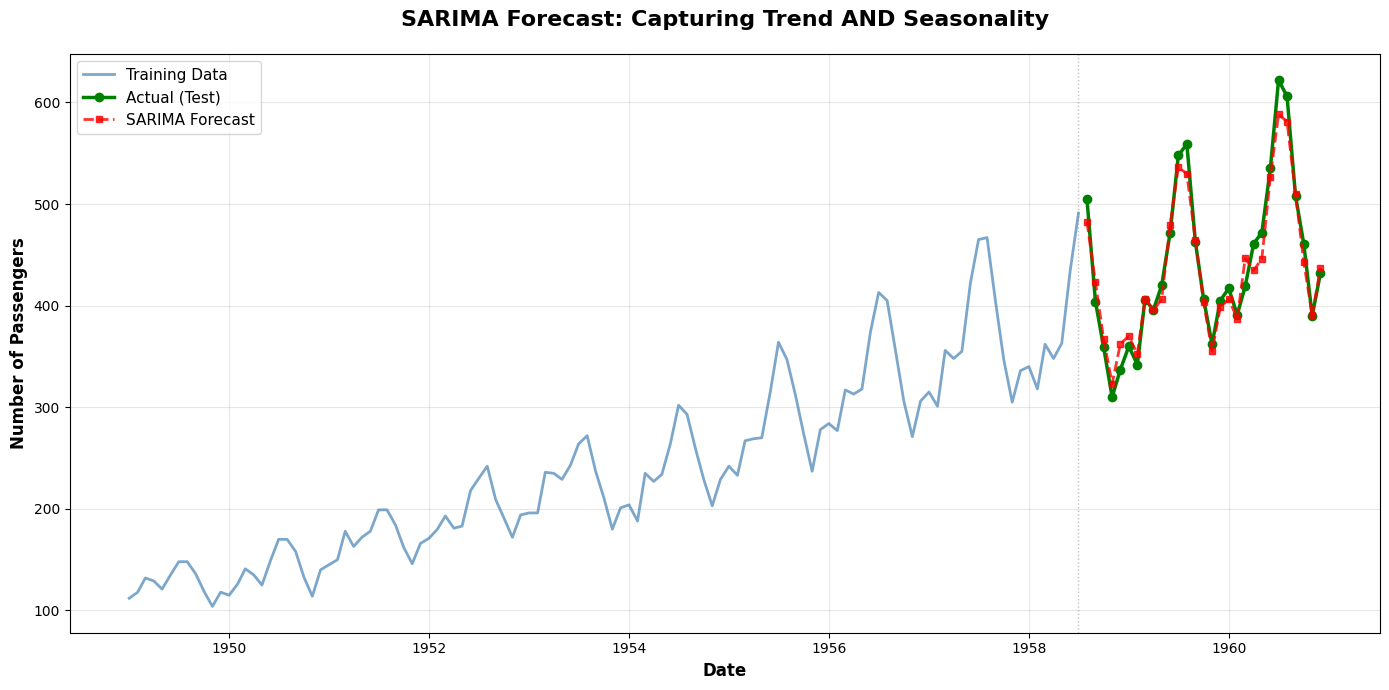


🔍 Visual Analysis:
✅ Does SARIMA capture the upward trend?
✅ Does SARIMA capture the seasonal pattern (summer peaks, winter lows)?
✅ How close are the red and green lines?
💡 SARIMA should handle both trend and seasonality better than ARIMA


In [15]:
# Visualize SARIMA forecasts
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['#Passengers'], linewidth=2, color='steelblue', 
         label='Training Data', alpha=0.7)
plt.plot(test.index, test['#Passengers'], linewidth=2.5, color='green', 
         label='Actual (Test)', marker='o', markersize=6)
plt.plot(test.index, sarima_forecasts, linewidth=2, color='red', 
         linestyle='--', label='SARIMA Forecast', alpha=0.8, marker='s', markersize=4)
plt.axvline(x=train.index.max(), color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.title('SARIMA Forecast: Capturing Trend AND Seasonality', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Number of Passengers', fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔍 Visual Analysis:")
print("✅ Does SARIMA capture the upward trend?")
print("✅ Does SARIMA capture the seasonal pattern (summer peaks, winter lows)?")
print("✅ How close are the red and green lines?")
print("💡 SARIMA should handle both trend and seasonality better than ARIMA")


## Section 4: Complete Model Comparison

Now let's compare ALL methods we've learned:
1. Naive
2. Moving Average
3. Seasonal Naive
4. ARIMA
5. SARIMA

This will help us see which method works best for our data!


In [16]:
# Create all forecasts for comparison
actual = test['#Passengers'].values

# 1. Naive forecast
naive_forecast = [train['#Passengers'].iloc[-1]] * len(test)

# 2. Moving Average (12 months)
ma_forecast = [train['#Passengers'].tail(12).mean()] * len(test)

# 3. Seasonal Naive
test['month_num'] = test.index.month
train['month_num'] = train.index.month
seasonal_naive_forecast = []
for idx, row in test.iterrows():
    month = row['month_num']
    same_month = train[train['month_num'] == month]
    if len(same_month) > 0:
        seasonal_naive_forecast.append(same_month['#Passengers'].iloc[-1])
    else:
        seasonal_naive_forecast.append(train['#Passengers'].iloc[-1])

# 4. ARIMA (from previous notebook - rebuild quickly)
arima_model_simple = auto_arima(train_boxcox,
                                start_p=0, start_q=0,
                                max_p=3, max_q=3,
                                d=1,
                                seasonal=False,
                                stepwise=True,
                                suppress_warnings=True,
                                error_action='ignore',
                                trace=False)
arima_forecasts_boxcox = arima_model_simple.predict(n_periods=len(test))
arima_forecasts = inv_boxcox(arima_forecasts_boxcox, lambda_param)

# 5. SARIMA (already created above)

print("✅ All forecasts created")
print("   Ready to compare all methods")


✅ All forecasts created
   Ready to compare all methods


In [17]:
# Calculate metrics for all methods
def calculate_metrics(actual, forecast, model_name="Model"):
    """Calculate and return MAE, MAPE, and RMSE"""
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return {'Model': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}

# Calculate for all methods
all_results = [
    calculate_metrics(actual, naive_forecast, "Naive"),
    calculate_metrics(actual, ma_forecast, "Moving Average (12mo)"),
    calculate_metrics(actual, seasonal_naive_forecast, "Seasonal Naive"),
    calculate_metrics(actual, arima_forecasts, "ARIMA"),
    calculate_metrics(actual, sarima_forecasts, "SARIMA")
]

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("COMPLETE MODEL COMPARISON: Which Method is Best?")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Find best model for each metric
print("\n📊 Best Model for Each Metric:")
print(f"   Best MAE:  {comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']} ({comparison_df['MAE'].min():.2f})")
print(f"   Best MAPE: {comparison_df.loc[comparison_df['MAPE'].idxmin(), 'Model']} ({comparison_df['MAPE'].min():.2f}%)")
print(f"   Best RMSE: {comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']} ({comparison_df['RMSE'].min():.2f})")

print("\n💡 Key Insights:")
print("✅ Lower values = Better forecasts")
print("✅ SARIMA should perform best for seasonal data")
print("✅ Seasonal Naive is often surprisingly good for seasonal data")
print("✅ Simple methods (naive, MA) are usually worst")



COMPLETE MODEL COMPARISON: Which Method is Best?
                Model       MAE      MAPE       RMSE
                Naive 81.448276 20.200133  93.133941
Moving Average (12mo) 76.942529 15.830374 100.982909
       Seasonal Naive 64.758621 14.037901  75.233888
                ARIMA 75.778099 18.485193  84.928192
               SARIMA 13.007110  2.904703  16.327148

📊 Best Model for Each Metric:
   Best MAE:  SARIMA (13.01)
   Best MAPE: SARIMA (2.90%)
   Best RMSE: SARIMA (16.33)

💡 Key Insights:
✅ Lower values = Better forecasts
✅ SARIMA should perform best for seasonal data
✅ Seasonal Naive is often surprisingly good for seasonal data
✅ Simple methods (naive, MA) are usually worst


### Visual Comparison of All Methods

Let's see all methods plotted together:


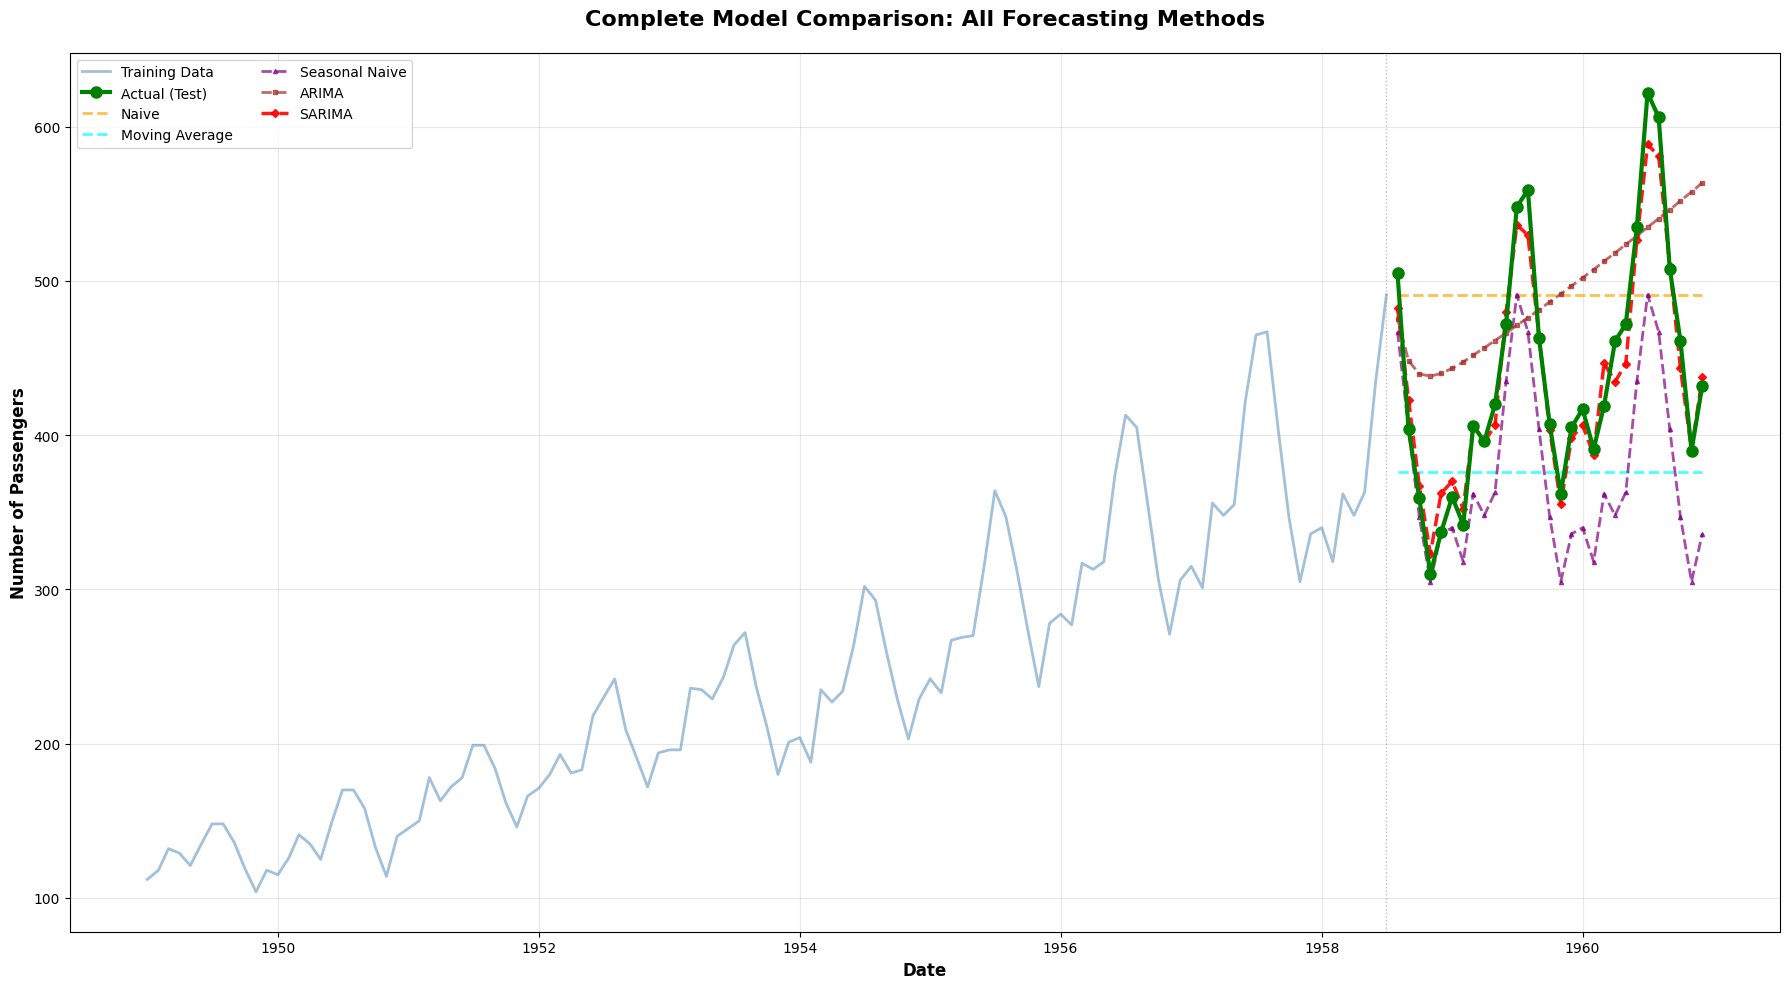


🔍 Visual Comparison:
✅ Which forecast follows the actual (green) line most closely?
✅ Which captures seasonality best?
✅ Which captures trend best?
💡 SARIMA should be closest to actual because it handles both trend and seasonality


In [18]:
# Visual comparison of all forecasting methods
plt.figure(figsize=(18, 10))
plt.plot(train.index, train['#Passengers'], linewidth=2, color='steelblue', 
         label='Training Data', alpha=0.5)
plt.plot(test.index, test['#Passengers'], linewidth=3, color='green', 
         label='Actual (Test)', marker='o', markersize=8, zorder=10)

# Plot all forecasts
plt.plot(test.index, naive_forecast, linewidth=2, color='orange', 
         linestyle='--', label='Naive', alpha=0.7)
plt.plot(test.index, ma_forecast, linewidth=2, color='cyan', 
         linestyle='--', label='Moving Average', alpha=0.7)
plt.plot(test.index, seasonal_naive_forecast, linewidth=2, color='purple', 
         linestyle='--', label='Seasonal Naive', alpha=0.7, marker='^', markersize=3)
plt.plot(test.index, arima_forecasts, linewidth=2, color='brown', 
         linestyle='--', label='ARIMA', alpha=0.7, marker='s', markersize=3)
plt.plot(test.index, sarima_forecasts, linewidth=2.5, color='red', 
         linestyle='--', label='SARIMA', alpha=0.9, marker='D', markersize=4)

plt.axvline(x=train.index.max(), color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.title('Complete Model Comparison: All Forecasting Methods', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Number of Passengers', fontsize=12, fontweight='bold')
plt.legend(fontsize=10, loc='upper left', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔍 Visual Comparison:")
print("✅ Which forecast follows the actual (green) line most closely?")
print("✅ Which captures seasonality best?")
print("✅ Which captures trend best?")
print("💡 SARIMA should be closest to actual because it handles both trend and seasonality")


## Section 5: Which Model Should You Choose?

### Decision Guide

**1. Data has NO trend and NO seasonality:**
   - Use: **Naive** or **Moving Average**
   - Example: Random fluctuations around a constant level

**2. Data has trend but NO seasonality:**
   - Use: **ARIMA**
   - Example: Steadily growing sales with no seasonal pattern

**3. Data has seasonality (with or without trend):**
   - Use: **SARIMA** or **Seasonal Naive**
   - Example: Our airline data (yearly seasonality)
   - **SARIMA** is better for complex patterns
   - **Seasonal Naive** is simpler and often good enough

**4. Quick baseline needed:**
   - Use: **Naive** or **Seasonal Naive**
   - Example: Need a forecast in 5 minutes

**5. Best accuracy needed:**
   - Use: **SARIMA** (for seasonal data) or **ARIMA** (for non-seasonal data)
   - Example: Important business decision requiring accurate forecasts

### For Our Airline Data

**Best choice: SARIMA**
- ✅ Has strong seasonality (yearly pattern)
- ✅ Has upward trend
- ✅ SARIMA handles both explicitly
- ✅ Best accuracy for this type of data

**Alternative: Seasonal Naive**
- ✅ Much simpler
- ✅ Often performs well for seasonal data
- ✅ Good baseline to compare against
- ⚠️  Misses the trend (but might be "good enough")

**Think About It:** When might you choose Seasonal Naive over SARIMA even if SARIMA is more accurate?


## Section 6: Complete Workflow Recap

Let's recap the complete time series forecasting workflow we've learned:

### Step 1: Load and Explore Data
- Load time series data
- Set proper date index
- Visualize to understand patterns

### Step 2: Understand Components
- Identify trend, seasonality, noise
- Use decomposition to see components separately
- Determine if pattern is additive or multiplicative

### Step 3: Prepare Data
- Make data stationary (if needed for ARIMA/SARIMA)
- Apply transformations (log, Box-Cox, differencing)
- Split into train/test (time-aware split)

### Step 4: Build Models
- Start with simple baselines (naive, moving average)
- Try ARIMA for trend data
- Try SARIMA for seasonal data
- Use auto-ARIMA/auto-SARIMA for parameter selection

### Step 5: Evaluate Models
- Calculate MAE, MAPE, RMSE
- Visualize forecasts vs actuals
- Compare all methods
- Choose the best model

### Step 6: Make Forecasts
- Use the best model to forecast future periods
- Understand model limitations
- Communicate results to stakeholders

**Think About It:** Can you think of a time series problem where you would use this workflow?


## Summary: Key Takeaways

This notebook completed our time series forecasting journey:

### What We Learned

1. **SARIMA (Seasonal ARIMA):**
   - Extends ARIMA with seasonal components
   - Handles both trend AND seasonality explicitly
   - Perfect for data with repeating patterns
   - Parameters: (p, d, q)(P, D, Q, s)

2. **Model Comparison:**
   - Always compare multiple methods
   - Simple methods are good baselines
   - Complex methods (SARIMA) often perform best for complex data
   - But simple methods (Seasonal Naive) can be surprisingly good

3. **Model Selection:**
   - Choose based on your data characteristics
   - Consider complexity vs accuracy trade-off
   - Sometimes simple is "good enough"

4. **Complete Workflow:**
   - Load → Explore → Prepare → Model → Evaluate → Forecast
   - Each step builds on the previous
   - Evaluation is critical at every stage

### Key Insights

- **SARIMA is powerful:** Best for seasonal data with trends
- **Comparison matters:** Always compare to baselines
- **Context matters:** Choose the right tool for your data
- **Simple can be good:** Don't overcomplicate if simple works

### Why This Matters

Understanding the complete workflow helps you:
- Choose the right forecasting method
- Build accurate forecasts
- Communicate results effectively
- Make better business decisions

### Congratulations

You've completed the time series forecasting course! You now know:
- ✅ How to work with time series data
- ✅ How to identify patterns and components
- ✅ How to prepare data for modeling
- ✅ How to build and evaluate forecasts
- ✅ How to choose the best model

**Remember:** Good forecasting is about understanding your data, choosing the right method, and always evaluating your results. Practice makes perfect

